# <span style="color:red"> Main Modelling - SVM - Gridsearch </span>
* read in pickle
* keep 3 translators
* final selected features based on initial analysis with logistic regression
* drop 'A Wild Sheep Chase' due to unique text
* run XGboosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.preprocessing import label_binarize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from xgboost import XGBClassifier

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [3]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,where_adv,too_adv,now_adv,all_adv,then_adv,just_adv,really_adv,there_adv,only_adv,even_adv,as_adv,always_adv,when_adv,again_adv,here_adv,maybe_adv,still_adv,back_adv,why_adv,very_adv,never_adv,how_adv,whole_adj,small_adj,long_adj,able_adj,more_adj,sure_adj,big_adj,last_adj,bad_adj,old_adj,same_adj,good_adj,new_adj,only_adj,different_adj,other_adj,next_adj,few_adj,much_adj,hard_adj,real_adj,young_adj,own_adj,first_adj,deep_adj,strange_adj,little_adj,right_adj
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(5253, 141)

In [5]:
# df.columns

### Drop 'A Wild Sheep Chase' 

In [6]:
df = df[df['book_title'] != 'A Wild Sheep Chase']

### Check the baseline

In [7]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.4364282726892514

### Select Predictor Variables

In [8]:
def feature_select(basic_counts=True, vader=False, pos_counts=False, 
                   words=False, adv=False, adj=False):
    '''create column list depending on features to include in the modelling'''
    columns = []
    if basic_counts:
        columns += [i for i in df.columns if i.startswith('n_') & i.endswith('_norm')]
    if vader:
        columns += [i for i in df.columns if i.startswith('vader_')]
    if pos_counts:
        columns += [i for i in df.columns if i.endswith('_count_norm')]
    if words:
        columns += [i for i in df.columns if i.endswith('_w')]
    if adj:
        columns += [i for i in df.columns if i.endswith('_adj')]
    if adv:
        columns += [i for i in df.columns if i.endswith('_adv')]
    return columns

In [9]:
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

### Set Target and Predictor variables

In [10]:
X = df[predictor_cols]
y = df['trans_code']

### Make Train Test Split with stratify on y

In [11]:
# stratify based on your target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

### Standardise the predictor variables

In [12]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### SVM classification with grid search

In [19]:
model = SVC(gamma='auto', kernel='rbf', probability=True,)
parameters = {
    "C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "gamma":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "shrinking": [True, False]
    }
#passing the scoring function in the GridSearchCV
svm_gs_01 = GridSearchCV(model,
                        parameters,
                        refit=True,
                        cv=5, 
                        n_jobs=-1,
                        verbose=1)


svm_gs_01.fit(X_train, y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed: 31.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'shrinking': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [15]:
def model_gridsearch_score(model, X_train, y_train, X_test, y_test):
    
    # print the grid search results
    results_dict = {}
    print('Best Parameters:')
    print(model.best_params_)
    print('Best estimator mean cross validated training score:')
    print(model.best_score_)
    print('Best estimator score on the full training set:')
    print(model.score(X_train, y_train))
    print('Best estimator score on the test set:')
    print(model.score(X_test, y_test))
    print('ROC-AUC score on the test set:')
    
    # store the grid search results as a dictionary
    y_bin = label_binarize(y_test, model.classes_)
    for i, class_ in enumerate(model.classes_):
        print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],model.predict_proba(X_test)[:,i]),2))
    results_dict['Best_Parameters'] = model.best_params_
    results_dict['Best_CV_Score'] = model.best_score_
    results_dict['Best_Train_Score'] = model.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.score(X_test, y_test)
    results_dict['AUC_Class_0'] = roc_auc_score(y_bin[:,0],model.predict_proba(X_test)[:,0])
    results_dict['AUC_Class_1'] = roc_auc_score(y_bin[:,1],model.predict_proba(X_test)[:,1])
    results_dict['AUC_Class_2'] = roc_auc_score(y_bin[:,2],model.predict_proba(X_test)[:,2])
    predictions = model.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])

    return results_dict

In [20]:
svm_gs_01_results = model_gridsearch_score(svm_gs_01, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 10, 'gamma': 0.001, 'shrinking': True}
Best estimator mean cross validated training score:
0.6956862745098039
Best estimator score on the full training set:
0.7686274509803922
Best estimator score on the test set:
0.7042842215256009
ROC-AUC score on the test set:
Class 0: 0.85
Class 1: 0.88
Class 2: 0.86


### Save the model

In [30]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'svm_gs_01_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(svm_gs_01, fp)

In [22]:
model = LinearSVC()
parameters = {
    "C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    }
#passing the scoring function in the GridSearchCV
svm_gs_02 = GridSearchCV(model,
                        parameters,
                        refit=True,
                        cv=5, 
                        n_jobs=-1,
                        verbose=2)


svm_gs_02.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:   20.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   26.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [24]:
svm_gs_02_results = model_gridsearch_score(svm_gs_02, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 0.1}
Best estimator mean cross validated training score:
0.6943790849673203
Best estimator score on the full training set:
0.7171241830065359
Best estimator score on the test set:
0.7053291536050157
ROC-AUC score on the test set:


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

### Save the model

In [31]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'svm_gs_02_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(svm_gs_02, fp)

In [21]:
svm_gs_03.best_estimator_.coef_

array([[ 0.45968183, -0.12648568,  0.20403922,  0.29673079,  0.11423739,
         0.09824188,  0.75427647, -0.13694035, -0.47739991, -0.47437816,
        -0.39493514, -0.26912571, -0.26068967, -0.28042281, -0.23008184,
        -0.11691857, -0.191592  , -0.54568028, -0.12986141, -0.28965253,
         0.01591927],
       [-0.5582667 ,  0.42388257, -0.30684209, -0.23607682, -0.15510645,
        -0.09602781, -0.47233523,  0.16845389,  0.2232109 ,  0.14500646,
         0.08795584,  0.03352927,  0.04142292,  0.052837  ,  0.04490337,
         0.01733143, -0.17199014,  0.15482613, -0.0510581 , -0.05825682,
        -0.00649842],
       [ 0.08959669, -0.19077162,  0.09146544, -0.09374411,  0.05168657,
         0.01175896, -0.36498202, -0.00862945,  0.27120517,  0.34321052,
         0.30656204,  0.24384363,  0.24641658,  0.2341848 ,  0.18649984,
         0.09811681,  0.37044847,  0.38215817,  0.18120441,  0.34858044,
        -0.0121616 ]])

In [25]:
X_train.columns

Index(['n_sents_norm', 'n_words_norm', 'n_chars_norm', 'n_syllables_norm',
       'n_unique_words_norm', 'n_long_words_norm', 'n_monosyllable_words_norm',
       'n_polysyllable_words_norm', 'pron_count_norm', 'verb_count_norm',
       'det_count_norm', 'adj_count_norm', 'noun_count_norm', 'adp_count_norm',
       'cconj_count_norm', 'sconj_count_norm', 'adv_count_norm',
       'aux_count_norm', 'part_count_norm', 'propn_count_norm',
       'intj_count_norm', 'the_w', 'to_w', 'and_w', 'of_w', 'you_w', 'was_w',
       'he_w', 'she_w', 'had_w', 'said_w', 'like_w', 'just_w', 'time_w',
       'know_w', 'think_w', 'got_w', 'right_w', 'whole_adj', 'small_adj',
       'long_adj', 'able_adj', 'more_adj', 'sure_adj', 'big_adj', 'last_adj',
       'bad_adj', 'old_adj', 'same_adj', 'good_adj', 'new_adj', 'only_adj',
       'different_adj', 'other_adj', 'next_adj', 'few_adj', 'much_adj',
       'hard_adj', 'real_adj', 'young_adj', 'own_adj', 'first_adj', 'deep_adj',
       'strange_adj', 'little_a

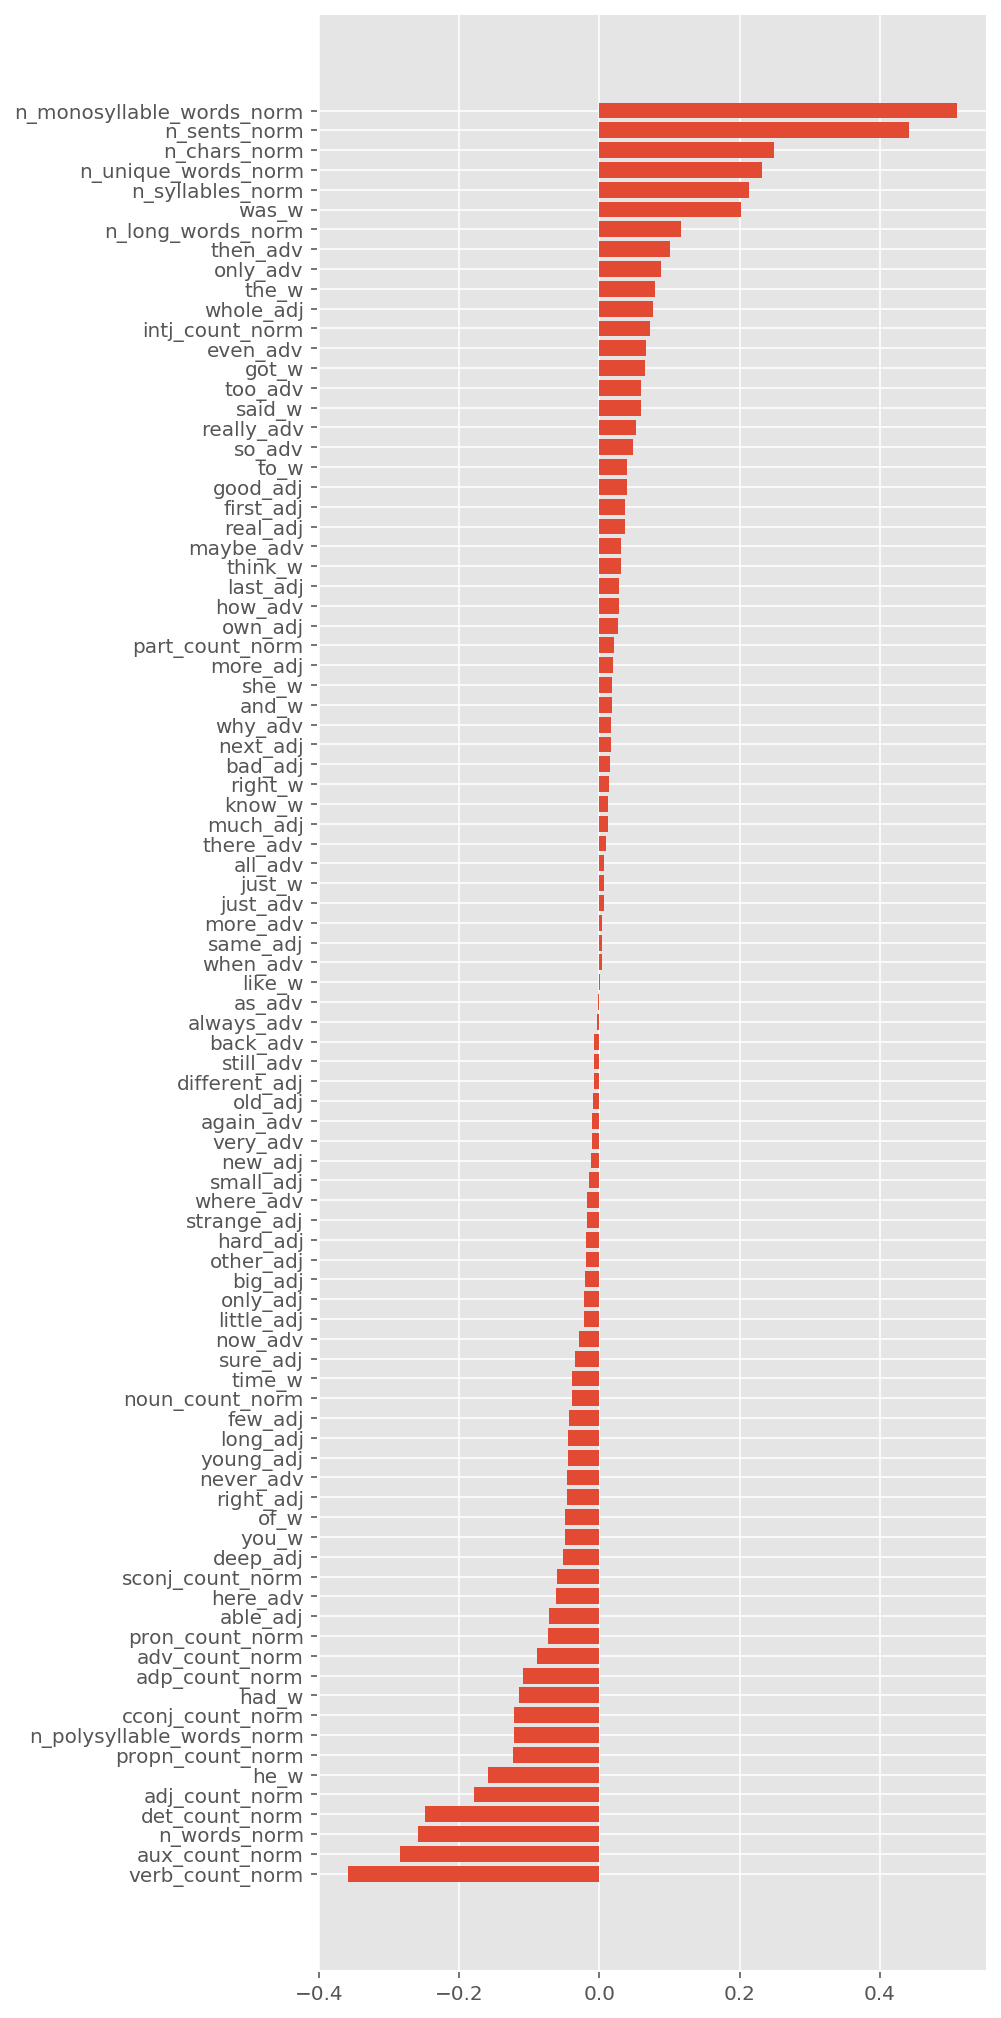

In [29]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    fig, ax = plt.subplots(figsize=(6, 18))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X_train.columns
f_importances(svm_gs_02.best_estimator_.coef_[0], features_names)

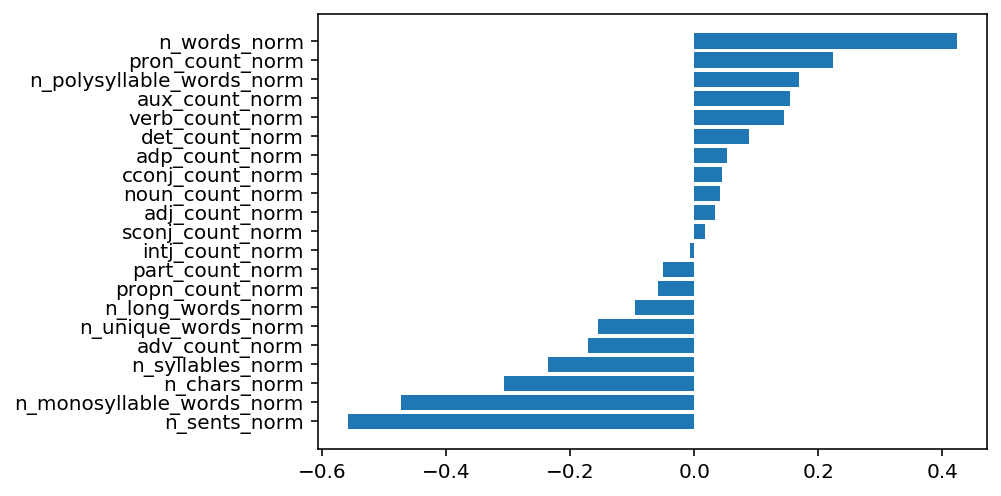

In [26]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X_train.columns
f_importances(svm_gs_03.best_estimator_.coef_[1], features_names)

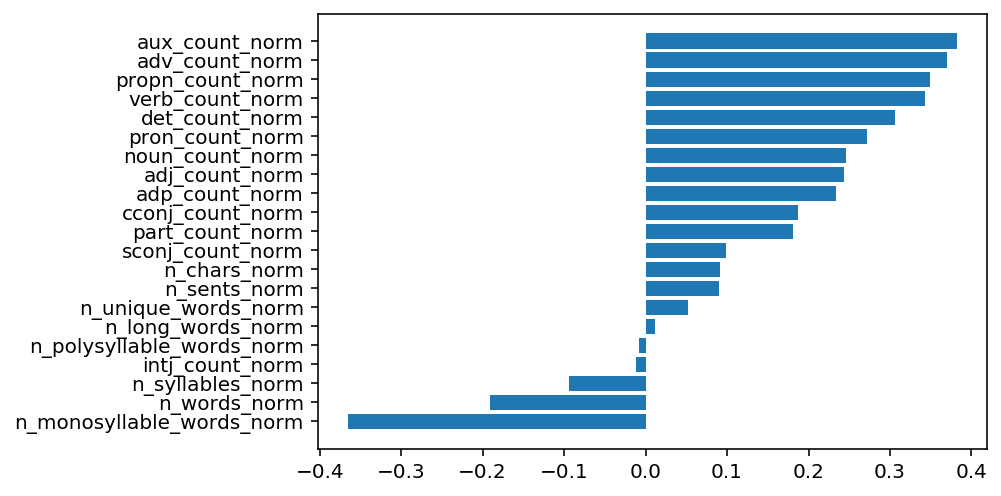

In [27]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X_train.columns
f_importances(svm_gs_03.best_estimator_.coef_[2], features_names)

### Confusion Matrix

In [28]:
predictions = svm_gs_01.predict(X_test)

In [29]:
conmat = confusion_matrix(
    y_test, predictions, labels=[0, 1, 2])

confusion = pd.DataFrame(conmat, index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                         columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel'])
confusion

,predicted birnbaum,predicted rubin,predicted gabriel
actual birnbaum,239,83,30
actual rubin,74,291,53
actual gabriel,67,99,115


* OK results

### Classification Report

In [30]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       352
           1       0.62      0.70      0.65       418
           2       0.58      0.41      0.48       281

    accuracy                           0.61      1051
   macro avg       0.61      0.59      0.60      1051
weighted avg       0.61      0.61      0.61      1051



### Save the models

In [31]:
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'svm_gs_01'
out_full_path = out_path + out_name + '.pkl'

In [35]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(svm_gs_01, fp)
    
# read back pickle
with open (out_full_path, 'rb') as fp:
    svm_gs_01_read = pickle.load(fp)

In [36]:
svm_gs_01_read.best_params_

{'C': 100, 'gamma': 0.001, 'shrinking': True}

In [37]:
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'svm_gs_02'
out_full_path = out_path + out_name + '.pkl'

In [38]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(svm_gs_02, fp)
    
# read back pickle
with open (out_full_path, 'rb') as fp:
    svm_gs_02_read = pickle.load(fp)

In [39]:
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'svm_gs_03'
out_full_path = out_path + out_name + '.pkl'

In [40]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(svm_gs_03, fp)
    
# read back pickle
with open (out_full_path, 'rb') as fp:
    svm_gs_03_read = pickle.load(fp)